In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tldextract
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [41]:
# Загрузка данных
data = pd.read_csv("Malicious-URLs.csv")

# Удаление дубликатов и пустых значений
data = data.drop_duplicates(subset="url").dropna()

# Проверка баланса классов
print("Распределение классов:")
print(data["label"].value_counts())

Распределение классов:
label
benign        10991
defacement     2727
phishing        912
malware         303
Name: count, dtype: int64


In [42]:
data["label"] = data["label"].map({'defacement': 0, 'phishing': 1, 'benign': 2, 'malware': 3})
data

,count,url,label
0,0,br-icloud.com.br,1
1,1,mp3raid.com/music/krizz_kaliko.html,2
2,2,bopsecrets.org/rexroth/cr/1.htm,2
3,3,http://www.garage-pirenne.be/index.php?option=...,0
4,4,http://adventure-nicaragua.net/index.php?optio...,0
...,...,...,...
14995,14995,fortdefianceind.com/,2
14996,14996,bookrags.com/lens/go.php?u=Hannah_Webster_Foster,2
14997,14997,burbankairport.com/parking/buses-trains.html,2
14998,14998,http://otomoto.pl/oferta/subaru-outback-legacy...,2


In [43]:
def extract_features(url):
    features = {}
    try:
        # Лексические признаки
        features["url_length"] = len(url)
        features["num_special_chars"] = sum(url.count(c) for c in ['@', '%', '//', '?', '='])
        
        # Анализ домена
        ext = tldextract.extract(url)
        features["subdomain_count"] = len(ext.subdomain.split('.')) if ext.subdomain else 0
        features["domain_length"] = len(ext.domain)
        features["has_ip"] = 1 if any(part.isdigit() for part in ext.domain.split('.')) else 0
        
        # Семантические признаки
        keywords = ['login', 'admin', 'exe', 'php', 'config', 'secure']
        features["keyword_count"] = sum(1 for kw in keywords if kw in url)
        return features
    except Exception as e:
        print(f"Ошибка при обработке URL {url}: {e}")
        return None

# Применение функции
features = data["url"].apply(extract_features)
valid_indices = features[features.notna()].index
data = data.loc[valid_indices]
features = features.loc[valid_indices]

# Создание DataFrame с признаками
features_df = pd.DataFrame(features.tolist())
labels = data["label"].values

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Токенизация URL
tokenizer = Tokenizer(num_words=10000, char_level=False, lower=True)
tokenizer.fit_on_texts(data["url"])
sequences = tokenizer.texts_to_sequences(data["url"])

# Выравнивание длины последовательностей
max_len = 100
X_padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

# Объединение с извлечёнными признаками
import numpy as np
X_features = np.array(features_df)
X_final = np.concatenate([X_padded, X_features], axis=1)


In [45]:
data["label"]

0        1
1        2
2        2
3        0
4        0
        ..
14995    2
14996    2
14997    2
14998    2
14999    2
Name: label, Length: 14933, dtype: int64

In [55]:
# Расчет веса для минорного класса (для параметра scale_pos_weight)
negative_count = sum(labels == 0)
positive_count = sum(labels == 1)
scale_pos_weight = negative_count / positive_count
print(f"\nВесовой коэффициент для минорного класса: {scale_pos_weight:.1f}")


Весовой коэффициент для минорного класса: 3.0


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

In [57]:
num_classes = len(np.unique(labels))
num_classes

4

In [61]:
# 6. Обучение XGBoost (исправленная версия)
# Создание DMatrix для XGBoost (оптимизированный формат данных)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# ----------------------------------------------------------

# Проверка количества классов
num_classes = len(np.unique(labels))
print(f"\nКоличество классов в данных: {num_classes}")

# Параметры модели (адаптированные под задачу)
params = {
    "objective": "binary:logistic" if num_classes == 2 else "multi:softprob",
    "eval_metric": "auc" if num_classes == 2 else "mlogloss",
    "booster": "gbtree",
    "eta": 0.05,
    "max_depth": 6,
    "scale_pos_weight": scale_pos_weight if num_classes == 2 else None,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Добавляем num_class только для многоклассовой классификации
if num_classes > 2:
    params["num_class"] = num_classes

# Обучение
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    verbose_eval=50
)



Количество классов в данных: 4
[0]	train-mlogloss:1.31613	test-mlogloss:1.31618
[50]	train-mlogloss:0.33497	test-mlogloss:0.34179
[100]	train-mlogloss:0.22913	test-mlogloss:0.24581
[150]	train-mlogloss:0.19761	test-mlogloss:0.22530
[200]	train-mlogloss:0.18144	test-mlogloss:0.21701
[250]	train-mlogloss:0.17023	test-mlogloss:0.21268
[300]	train-mlogloss:0.16108	test-mlogloss:0.20960
[350]	train-mlogloss:0.15223	test-mlogloss:0.20863
[400]	train-mlogloss:0.14486	test-mlogloss:0.20744
[450]	train-mlogloss:0.13807	test-mlogloss:0.20715
[500]	train-mlogloss:0.13206	test-mlogloss:0.20703
[507]	train-mlogloss:0.13131	test-mlogloss:0.20709


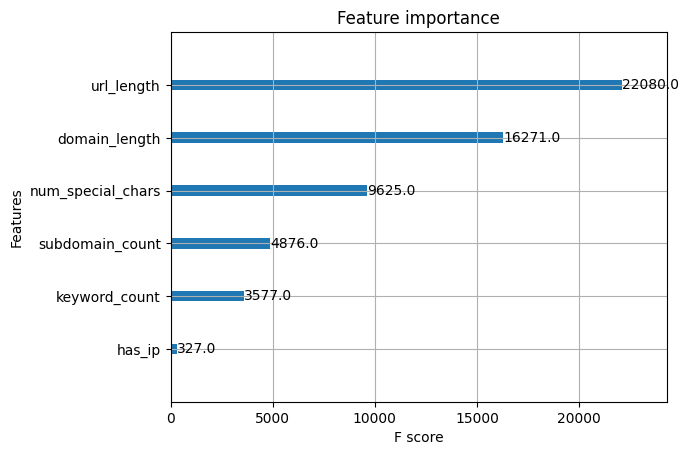

In [50]:
# Визуализируйте важность признаков
xgb.plot_importance(model, importance_type="weight")
plt.show()

In [62]:
# 7. Оценка модели (исправленная версия)
# ----------------------------------------------------------

# Предсказание вероятностей
y_pred_proba = model.predict(dtest)

# Для бинарной классификации: преобразование вероятностей в метки
if num_classes == 2:
    y_pred = (y_pred_proba > 0.5).astype(int)
# Для многоклассовой классификации: выбор класса с максимальной вероятностью
else:
    y_pred = np.argmax(y_pred_proba, axis=1)

# Убедимся, что y_test имеет правильный формат (не one-hot encoded)
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# Метрики
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if num_classes == 2:
    print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")
else:
    # Для многоклассовой задачи: ROC-AUC One-vs-Rest
    print(f"\nROC-AUC (OvR): {roc_auc_score(y_test, y_pred_proba, multi_class='ovr'):.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       545
           1       0.81      0.65      0.72       182
           2       0.96      0.97      0.97      2199
           3       0.85      0.46      0.60        61

    accuracy                           0.93      2987
   macro avg       0.87      0.75      0.79      2987
weighted avg       0.93      0.93      0.93      2987


ROC-AUC (OvR): 0.97


In [65]:
def predict_url(url: str, model, threshold: float = 0.5) -> str:
    try:
        # Шаг 1: Извлечение признаков
        features = extract_features(url)
        if not features:
            return "Ошибка: не удалось извлечь признаки из URL."
        
        # Шаг 2: Преобразование в DataFrame
        features_df = pd.DataFrame([features])
        
        # Шаг 3: Нормализация данных (если использовалась при обучении)
        if 'scaler' in globals():  # Проверка, определен ли scaler
            features_df = pd.DataFrame(scaler.transform(features_df), columns=features_df.columns)
        
        # Шаг 4: Предсказание вероятности
        if isinstance(model, xgb.Booster):  # Для XGBoost
            dtest = xgb.DMatrix(features_df)
            proba = model.predict(dtest)[0]
        elif hasattr(model, "predict_proba"):  # Для RandomForest, LightGBM и т.д.
            proba = model.predict_proba(features_df)[0][1]  # Вероятность класса 1
        else:
            return "Ошибка: неподдерживаемый тип модели."
        
        return np.argmax(proba)
    
    except Exception as e:
        return f"Ошибка предсказания: {str(e)}"

In [74]:
print(predict_url("https://www.google.com/business/?subid=ww-ww-et-g-awa-a-g_hpbfoot1_1!o2&utm_source=google.com&utm_medium=referral&utm_campaign=google_hpbfooter&fg=1", model, threshold=0.7))  # Строгая проверка

2
